# Imports and setup

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)

mpl.rcParams['image.cmap'] = 'magma'

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [3]:
data = at.Table.read("../../cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

In [4]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='GD-1'


p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=3)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

PyMultiNest not imported.  MultiNest fits will not work.


-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031354268696706, -3.1081604535822644
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.27966400893662, -3.16516602991575, 0.39918175447779325, 0.5336447547861581] 

Producing the polygon and mask


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


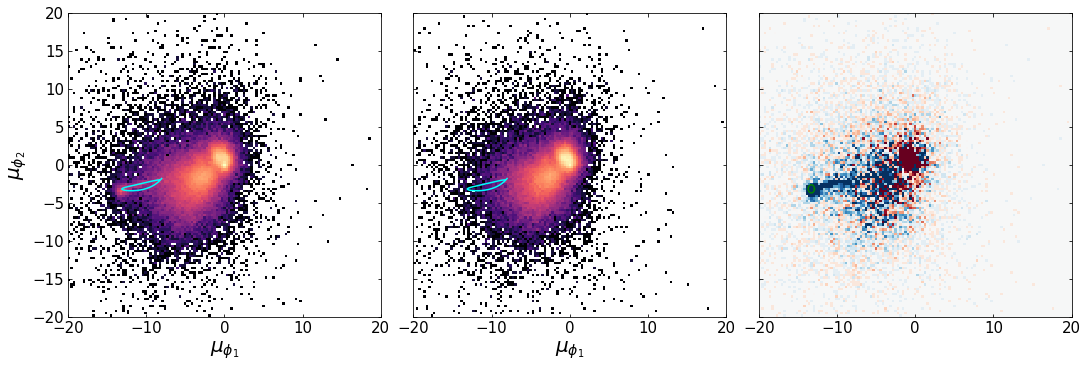

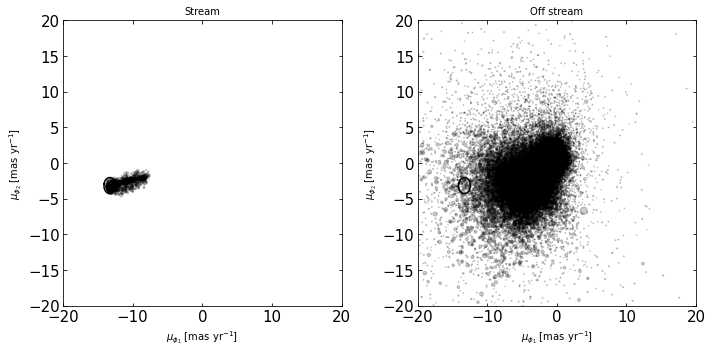

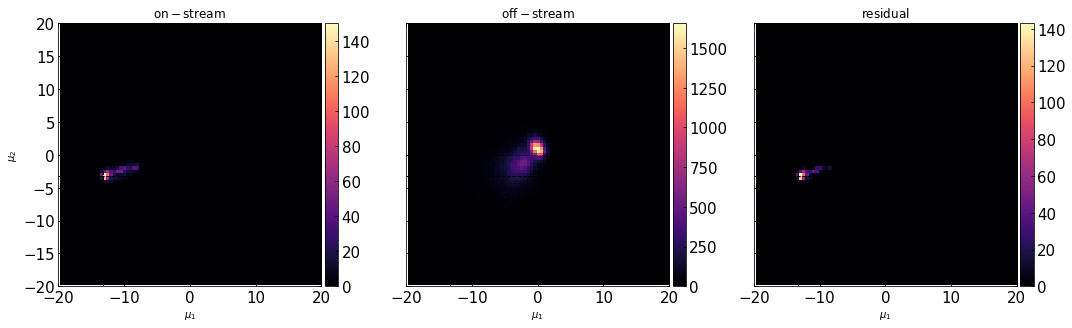

In [5]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [6]:
# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)
p.pmprint.vertices

array([[-15.09996078,  -5.41743859],
       [-15.09996078,   0.19860289],
       [ -6.01001683,   0.19860289],
       [ -6.01001683,  -5.41743859]])

In [7]:
GD1Base.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
GD1Base.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
GD1Base.default_grids['phi2'] = np.linspace(-7,3, 100)

GD1Base.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
GD1Base.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
GD1Base.coord_bounds['phi2'] = (-7,3)



GD1BackgroundModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
GD1BackgroundModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
GD1BackgroundModel.default_grids['phi2'] = np.linspace(-7,3, 100)

GD1BackgroundModel.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
GD1BackgroundModel.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
GD1BackgroundModel.coord_bounds['phi2'] = (-7,3)

GD1StreamModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
GD1StreamModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)

In [8]:
GD1Base.coord_bounds

{'phi1': (-100, 20),
 'phi2': (-7, 3),
 'pm1': (-15.099960783639158, -6.010016834305061),
 'pm2': (-5.417438593107988, 0.1986028915630751)}

In [9]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [127]:
len(bkg_data['phi1'])

34177

In [128]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

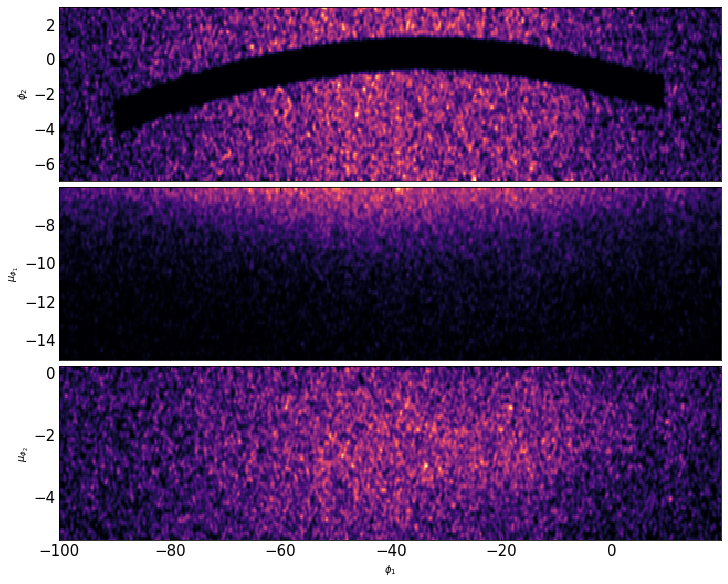

In [129]:
plot_data_projections(data=bkg_data, grids=GD1Base.default_grids,
                      smooth=1);

# Background

In [130]:
phi1_dens, _ = np.histogram(
    bkg_data["phi1"],
    bins=(GD1BackgroundModel.phi1_locs.shape[0]-1), density=True)

phi1_dens

array([0.0048675 , 0.00675792, 0.00947943, 0.01184977, 0.01155128,
       0.01038659, 0.00700373, 0.00477971])

In [137]:
x

array([-15.09977745, -14.91798306, -14.73618867, -14.55439427,
       -14.37259988, -14.19080549, -14.00901109, -13.8272167 ,
       -13.64542231, -13.46362791, -13.28183352, -13.10003913,
       -12.91824473, -12.73645034, -12.55465595, -12.37286155,
       -12.19106716, -12.00927277, -11.82747837, -11.64568398,
       -11.46388959, -11.28209519, -11.1003008 , -10.91850641,
       -10.73671201, -10.55491762, -10.37312323, -10.19132883,
       -10.00953444,  -9.82774005,  -9.64594565,  -9.46415126,
        -9.28235687,  -9.10056247,  -8.91876808,  -8.73697369,
        -8.55517929,  -8.3733849 ,  -8.19159051,  -8.00979611,
        -7.82800172,  -7.64620733,  -7.46441293,  -7.28261854,
        -7.10082414,  -6.91902975,  -6.73723536,  -6.55544096,
        -6.37364657,  -6.19185218,  -6.01005778])

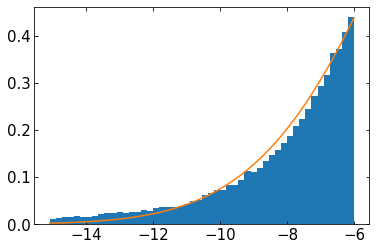

In [171]:
mean = 0 ; std_dev = np.e**1.45


_, x, _ = plt.hist(bkg_data['pm1'], density=True, bins=50)

plt.plot(x, truncnorm.pdf(x, (np.min(x)-mean) / std_dev, (np.max(x)-mean) / std_dev, loc=mean, scale=std_dev))
plt.show()

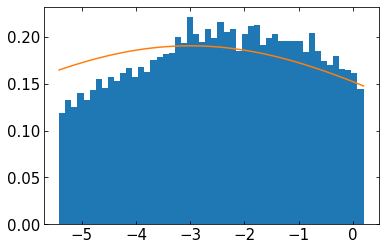

In [178]:
mean = -3 ; std_dev = np.e**1.5


_, x, _ = plt.hist(bkg_data['pm2'], density=True, bins=50)

plt.plot(x, truncnorm.pdf(x, (np.min(x)-mean) / std_dev, (np.max(x)-mean) / std_dev, loc=mean, scale=std_dev))
plt.show()

In [216]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    "phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi2": {},
    "pm1": {
        "w": np.full_like(GD1BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm1_knots, -4),
        "ln_std1": np.full_like(GD1BackgroundModel.pm1_knots, 1.1),
        "mean2": np.full_like(GD1BackgroundModel.pm1_knots, 0),
        "ln_std2": np.full_like(GD1BackgroundModel.pm1_knots, 1.4)
    },
    "pm2": {
        "w": np.full_like(GD1BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm2_knots, -2.),
        "ln_std1": np.full_like(GD1BackgroundModel.pm2_knots, 1),
        "mean2": np.full_like(GD1BackgroundModel.pm2_knots, -3),
        "ln_std2": np.full_like(GD1BackgroundModel.pm2_knots, 1.5)
    },
}
background_init = GD1BackgroundModel(bkg_init_p)

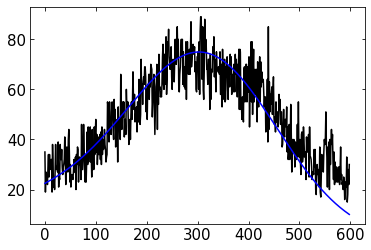

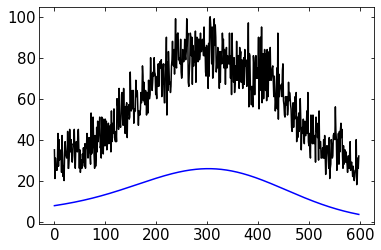

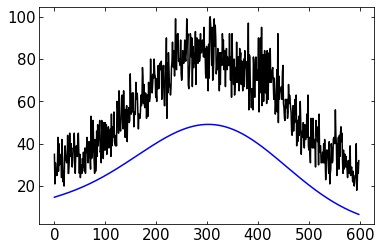

In [219]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

H_data2, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["pm1"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['pm1'])
)

H_data3, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["pm2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['pm2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

plt.figure(figsize=(6, 4))
plt.plot(H_data1.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b')

plt.figure(figsize=(6, 4))
plt.plot(H_data2.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='b')

plt.figure(figsize=(6, 4))
plt.plot(H_data3.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='b')

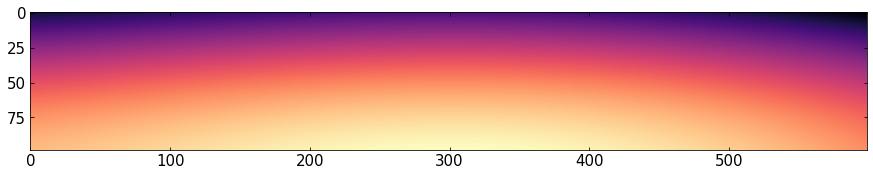

In [201]:
plt.figure(figsize=(15, 5))
plt.imshow(ln_ns[('phi1', 'pm1')])

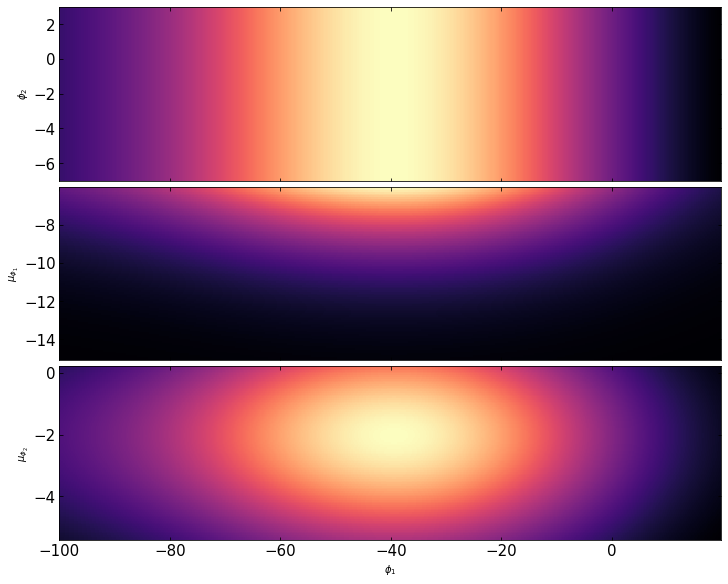

In [180]:
_ = background_init.plot_model_projections()

In [181]:
bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = GD1BackgroundModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(2.54626825, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]))

In [182]:
bkg_opt_pars

{'ln_N': Array(10.43930818, dtype=float64),
 'phi1': {'zs': Array([-2.49964551, -1.50065263, -0.50688578,  0.47423693,  1.455833  ,
          2.48012464,  3.49858695,  4.49998692], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([1.11710212, 1.16715272, 1.15428688, 1.18062705, 1.19203489,
         1.21487676, 1.22384289, 1.22051852, 1.21420892, 1.20372495,
         1.16176331, 1.17290478, 1.11661956], dtype=float64),
  'ln_std2': Array([1.42871314, 1.51321065, 1.49150765, 1.53579727, 1.55518992,
         1.5940233 , 1.61038991, 1.60546117, 1.59483937, 1.57631348,
         1.50402575, 1.52343008, 1.42793193], dtype=float64),
  'mean1': Array([-4.00051524, -4.00208621, -4.00180789, -4.00290701, -4.00342527,
         -4.00410557, -4.00416864, -4.00376921, -4.00350273, -4.00311718,
         -4.00186478, -4.00207759, -4.00046306], dtype=float64),
  'mean2': Array([-0.00380115, -0.01500531, -0.01231505, -0.01867353, -0.02130511,
         -0.02598738, -0.02753262, -0.02633625, -0.0249

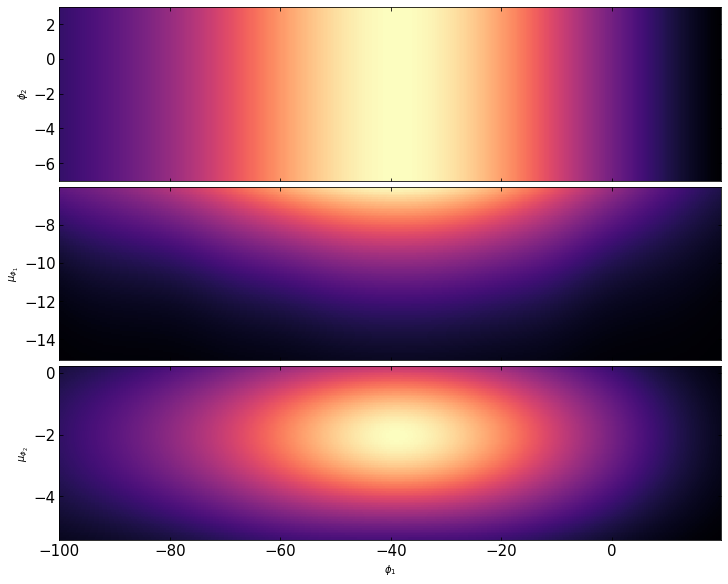

In [183]:
_ = background_opt.plot_model_projections()

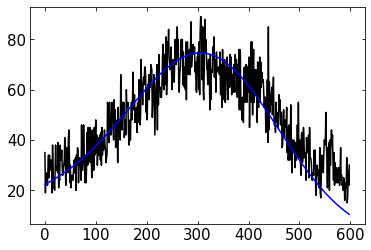

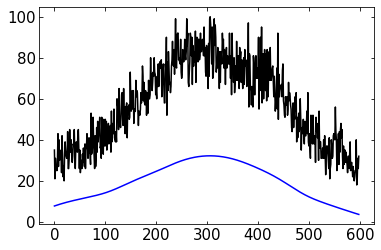

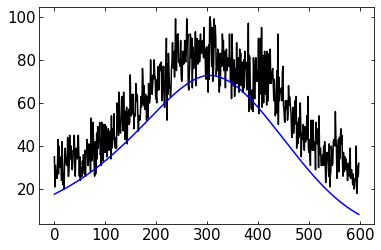

In [184]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)
H_data2, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["pm1"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['pm1'])
)
H_data3, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["pm2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['pm2'])
)
grids, ln_ns = background_opt.evaluate_on_2d_grids()

plt.figure(figsize=(6, 4))
plt.plot(H_data1.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b')

plt.figure(figsize=(6, 4))
plt.plot(H_data2.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='b')

plt.figure(figsize=(6, 4))
plt.plot(H_data3.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='b')

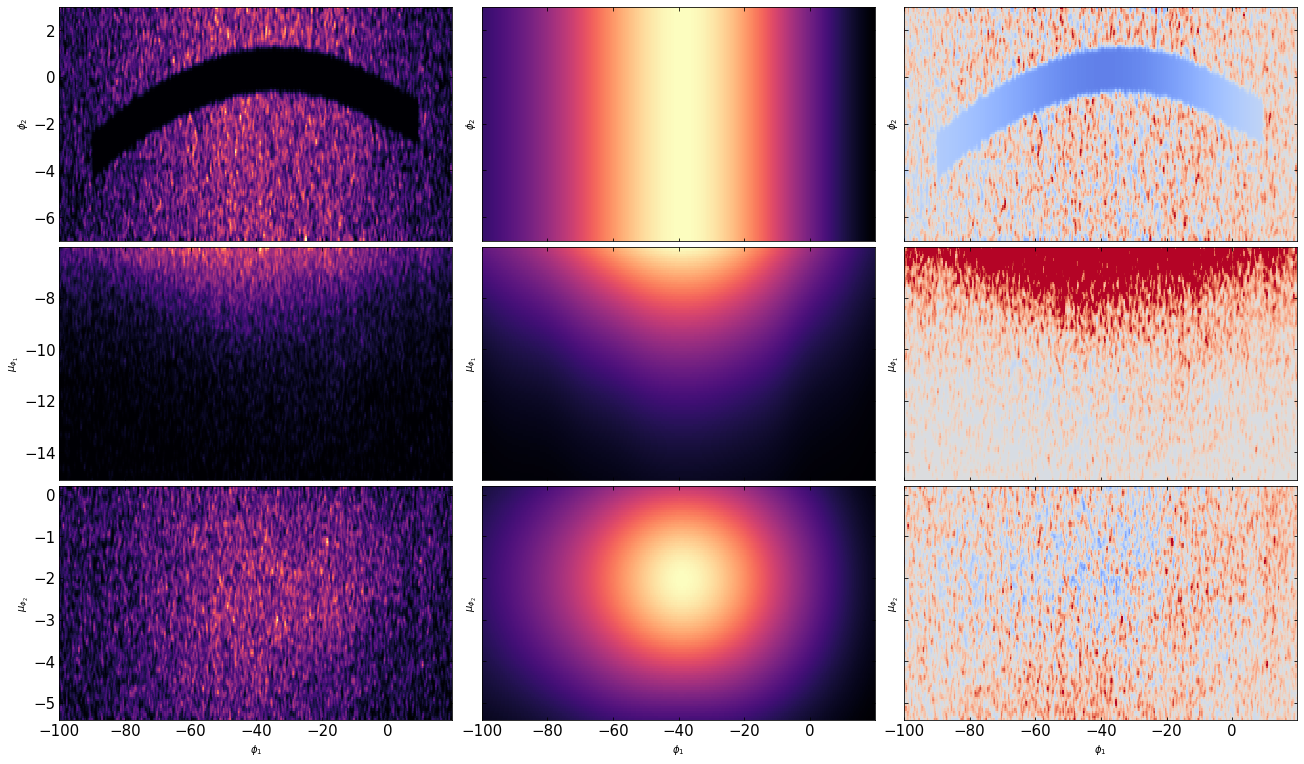

In [185]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Stream

In [154]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [155]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

In [156]:
np.e**10

22026.465794806703

In [157]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(GD1StreamModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(GD1StreamModel.phi2_knots),
        "ln_std": np.full_like(GD1StreamModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(GD1StreamModel.pm1_knots),
        "ln_std": np.full_like(GD1StreamModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(GD1StreamModel.pm2_knots),
        "ln_std": np.full_like(GD1StreamModel.pm2_knots, -1)
    }
}

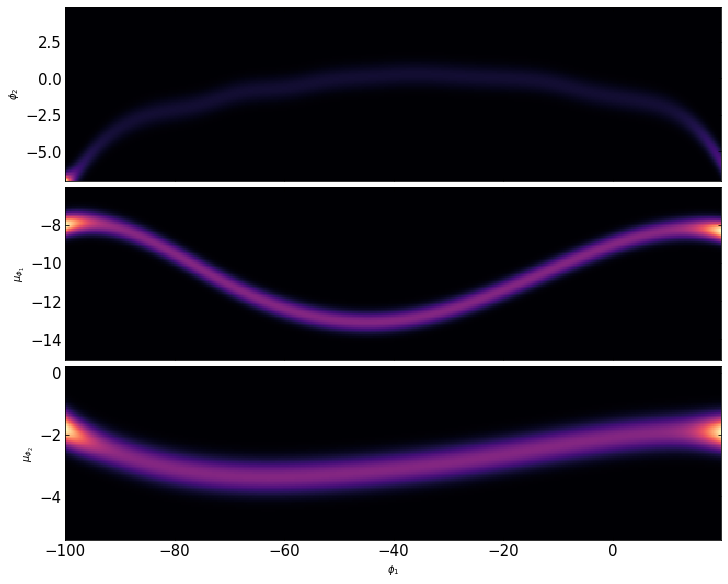

In [158]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [159]:
stream_init_p

{'ln_N': 7.330405211844402,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-7.88163477, -3.95341163, -2.42211648, -1.84441857, -0.95850907,
         -0.65285416, -0.1239385 ,  0.14401882,  0.29575805,  0.15567152,
          0.0156095 , -0.25665396, -0.97954984, -1.47919275, -2.45582047,
         -5.90023171]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
         -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -8.77103682, -11.15172534, -12.76884806,
         -13.02597314, -11.97714148, -10.18789348,  -8.59629564,
          -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -3.24562547, -3.27612746, -2.78970843, -2.09902309,
         -1.99723637]),
  'ln_std': array([-1., -1., -1., -1., -1., -1.])}}

In [160]:
stream_opt_pars, info = GD1StreamModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = GD1StreamModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.70121455, dtype=float64, weak_type=True), success=True, status=0, iter_num=948, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.12444592e-05  1.15912023e-04
  -4.11806358e-04 -3.08258798e-06  3.12536600e-04  5.20739987e-04
  -1.56488154e-04 -1.16033348e-05  2.08631559e-04  2.83054139e-05
  -3.31902311e-04 -4.49643708e-05  1.36171899e-05 -1.84241189e-04
  -4.63823726e-05 -4.67812304e-04 -5.39482336e-04  6.97212649e-05
   5.80945881e-05 -5.85459822e-04 -2.70417207e-04  0.00000000e+00
   1.99812507e-04  8.99373808e-05  2.10908627e-05  3.53583625e-06
   3.80426351e-07  7.45146247e-05  1.89953641e-05  7.04911538e-05
  -4.46152029e-07  1.98672567e-05 -5.35569311e-06  1.90893192e-05
   3.61888890e-05  7.21096489e-06  6.05582650e-07  4.53079943e-05
   4.80289059e-05 -8.42180797e-06 -2.19351860e-05 -1.05525166e-05
  -4.39214413e-05  3.81711565e-05  1.20218667e-05 -5.02387495

Text(0, 0.5, '$\\phi_2$')

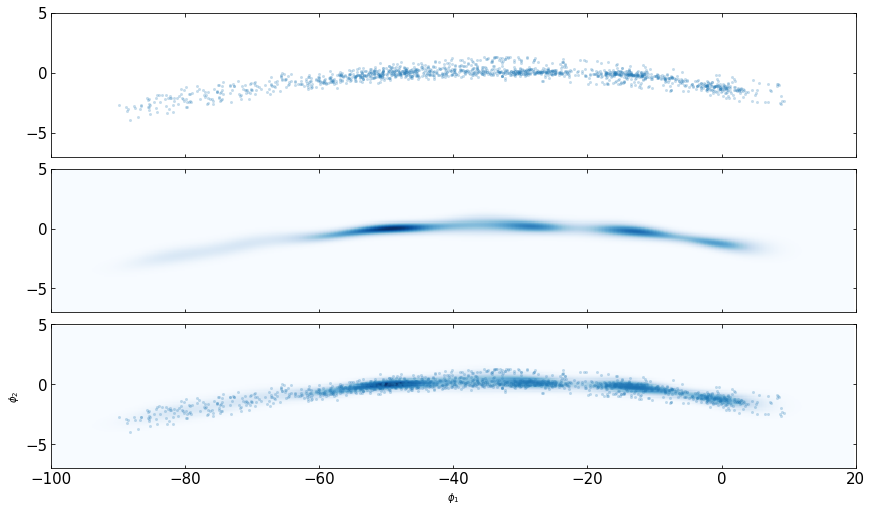

In [161]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

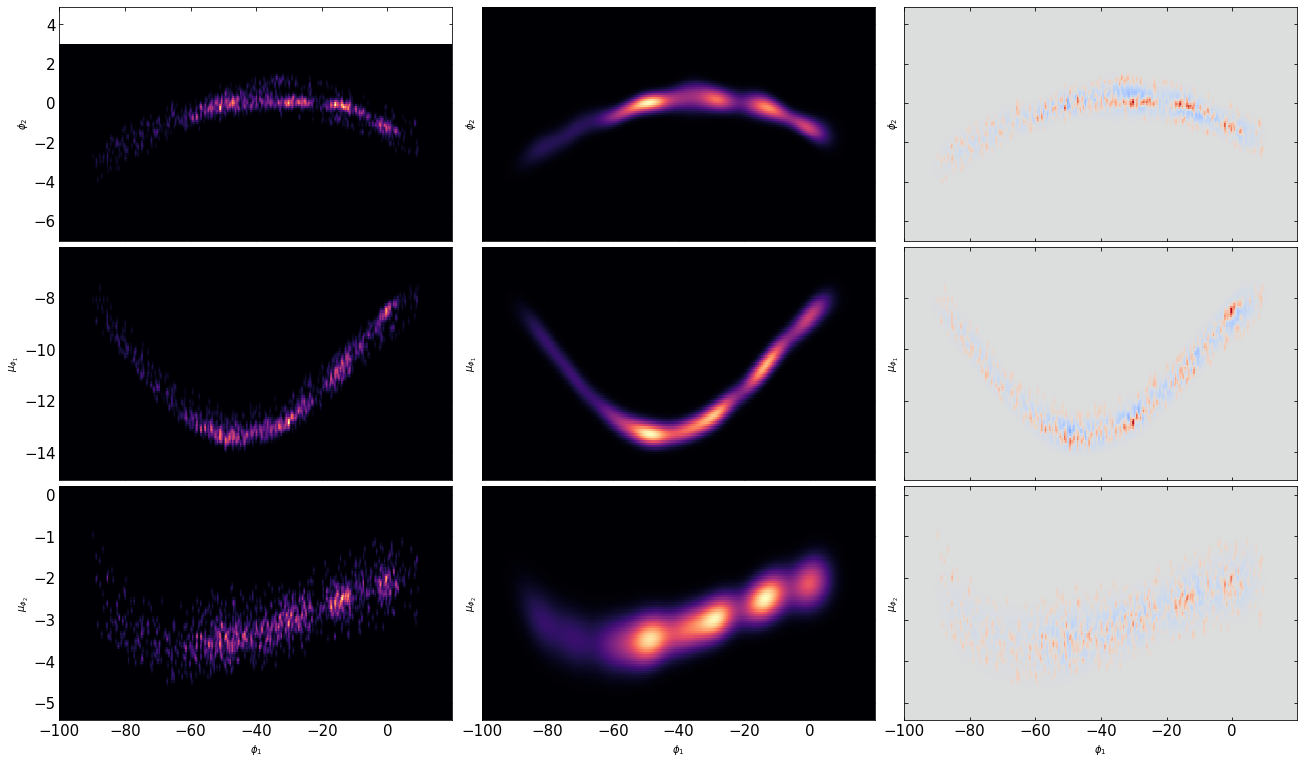

In [162]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [163]:
Components = [GD1StreamModel, GD1BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [164]:
mix_init = StreamMixtureModel(mix_params0, Components)

ValueError: All input arrays must have the same shape.

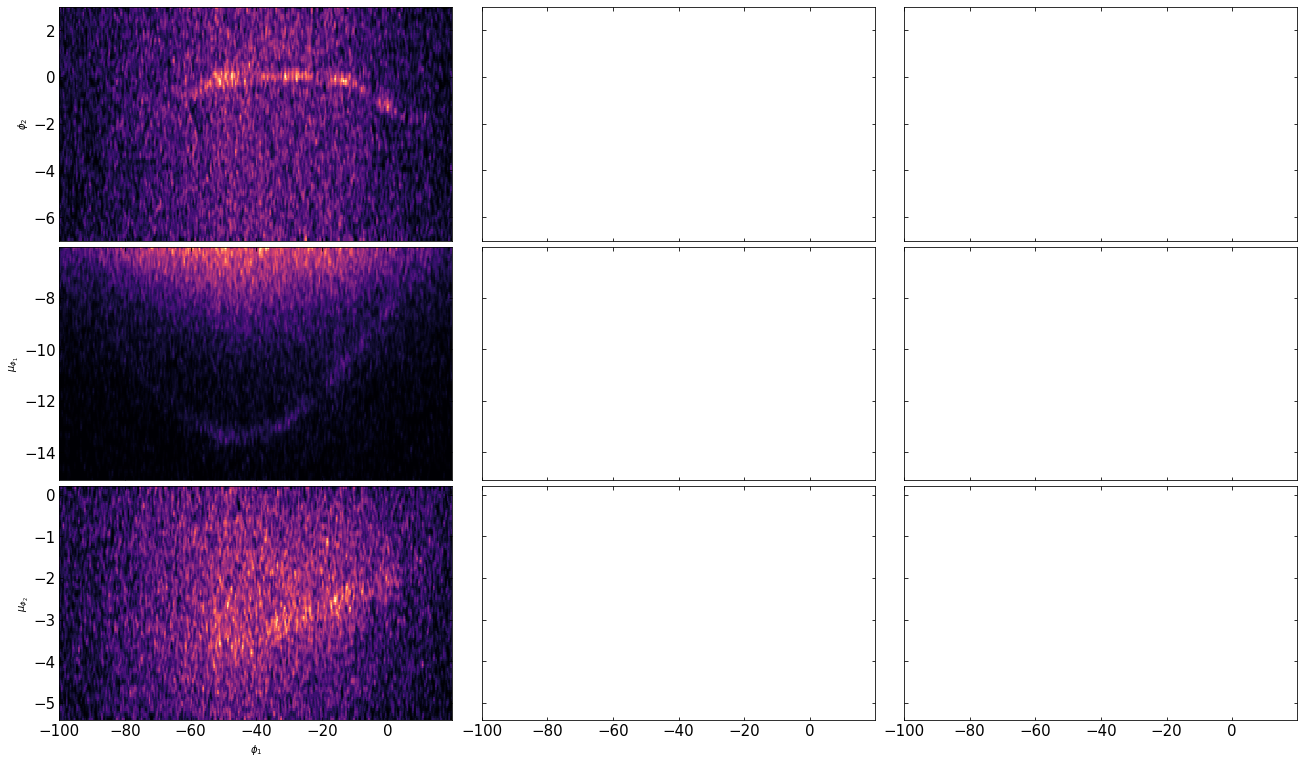

In [165]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [208]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(1.11735319, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]))

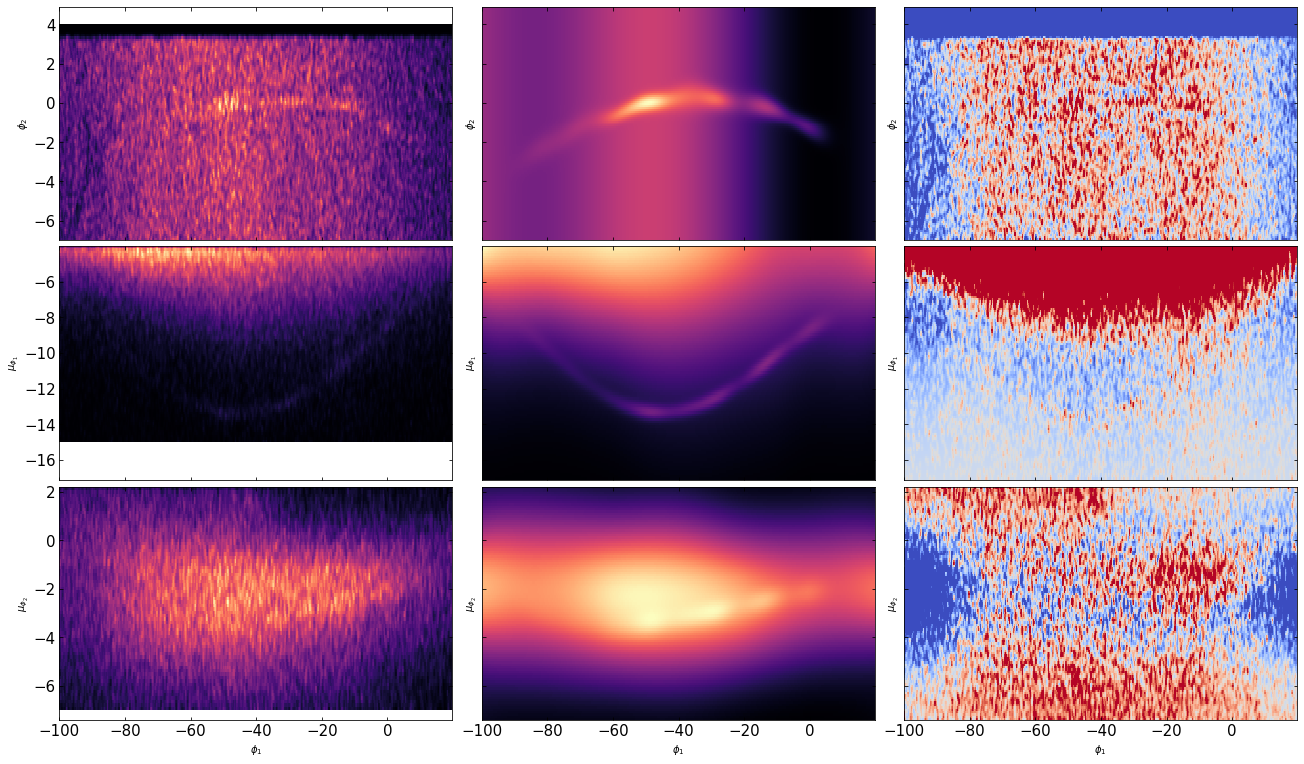

In [209]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [211]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(GD1OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

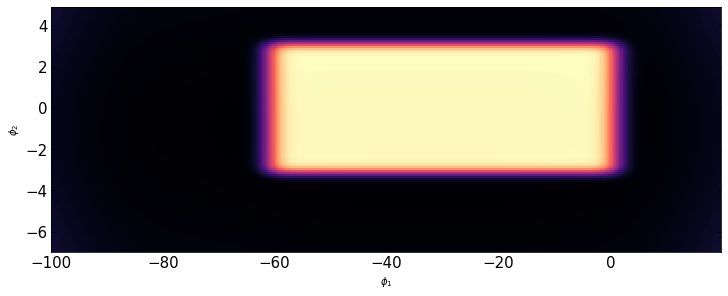

In [212]:
offtrack_model0 = GD1OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [213]:
full_Components = [GD1StreamModel, GD1BackgroundModel, GD1OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [214]:
full_mix_init = StreamMixtureModel(
    full_mix_params0,
    full_Components,
    tied_params=[
        (("offtrack", "pm1"), ("stream", "pm1")),
        (("offtrack", "pm2"), ("stream", "pm2")),
    ],
)

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

In [ ]:
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [ ]:
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5))

In [217]:
full_mix_opt_pars['stream']['pm1']

{'ln_std': Array([-0.86541515, -0.91688066, -1.06186763, -1.15438145, -1.25354065,
        -1.14996269, -1.09284736, -0.96356562, -0.96085753], dtype=float64),
 'mean': Array([ -8.23973304,  -9.00712161, -11.39111032, -13.03184141,
        -13.23629789, -12.15145871, -10.11117072,  -8.23814473,
         -8.53670427], dtype=float64)}

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

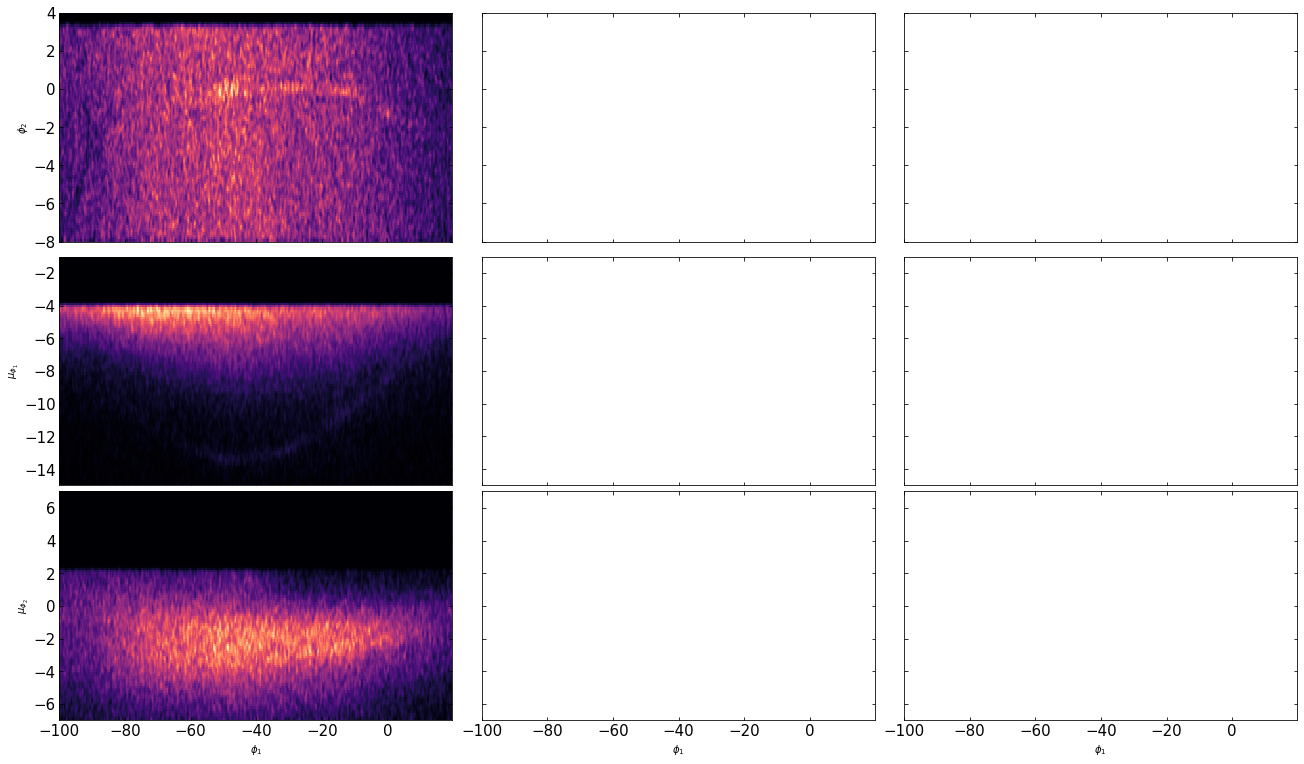

In [221]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")